# Darts

Experiment for doing forecasting of wind power prediction with darts

In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

from src.dataset import get_df_from_bucket

In [3]:
os.environ["EMAP_PROJECT_ID"]="tmrow-152415"
os.environ["POSTGRES_DB"]="electricitymap"
os.environ["POSTGRES_HOST"]="127.0.0.1"
os.environ["POSTGRES_USER"]="readonly"
os.environ["POSTGRES_PORT"]="5432"

---

Get data

In [57]:
zone_keys = ["DK-DK1", "ES", "US-CENT-SWPP"]

df = get_df_from_bucket(zone_keys[0])
df = df.drop(columns=["zone_key"])
# Get rid of timezone info
df.index = df.index.tz_convert(None).to_pydatetime()

In [71]:
df.power_production_wind_avg.plot(kind="bar")

<AxesSubplot:xlabel='time'>

Error in callback <function flush_figures at 0x10e557c10> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:>

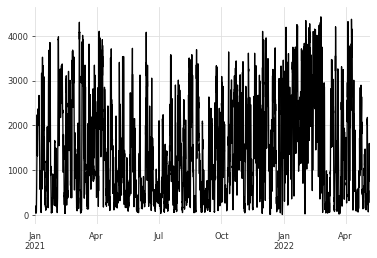

In [58]:
df.power_production_wind_avg.plot()

In [59]:
ts = TimeSeries.from_dataframe(df)
train, test = ts.split_before(0.75)

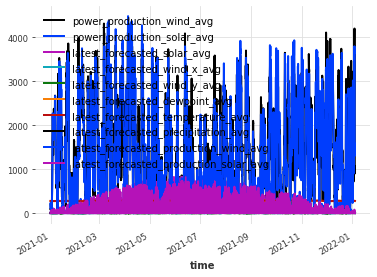

In [60]:
train.plot()

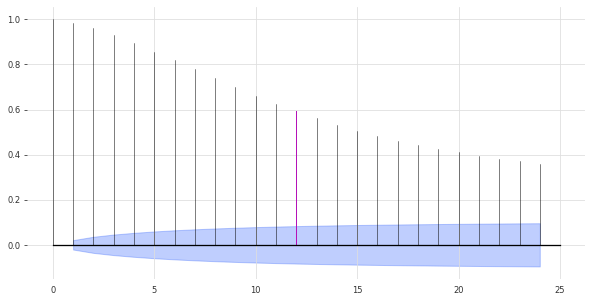

In [61]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train.univariate_component("power_production_wind_avg"), m=12, alpha=0.05)

In [62]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.metrics import mape

def eval_model(model):
    model.fit(train.univariate_component("power_production_wind_avg"))
    forecast = model.predict(len(test))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(test.univariate_component("power_production_wind_avg"), forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
2022-05-07 19:04:30 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24 obtains MAPE: 31331.46%


/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


model Prophet obtains MAPE: 293.74%
model Auto-ARIMA obtains MAPE: 162.51%
model Theta(2) obtains MAPE: 160.96%


/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [64]:
model = Theta()
model.fit(train.univariate_component("power_production_wind_avg"))
forecast = model.predict(len(test))

/Users/Ashitaka2/Desktop/mlops/mlops-ts-project/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


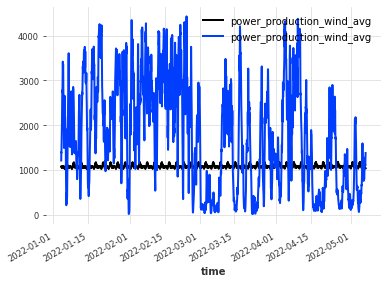

In [66]:
forecast.plot()
test.univariate_component("power_production_wind_avg").plot()